In [1]:
import numpy as np
from scipy.integrate import solve_bvp, solve_ivp
from matplotlib import pyplot as plt

# Create Model

In [2]:
class salt_lake():
    def __init__(self,k1, k2, params, tf,x0):
        """
        This function initializes the parameters for 
        our model
        parameters:
        -----------
        k1 (float): the first constant in the loss 
        function (multiplied by Q)
        k2 (float): the second constant in the loss 
        function (multipled by R)
        params (dict): a dictionary of the parameters used 
        in A and B
        tf (int): final time
        x0 (array): initial state
        """
        
        # Set Q
        self.Q = np.zeros((4,4))
        
        # Set A
        self.A = lambda t: np.array([[0,params['alpha'], -params['beta'], 0],
                        [params['epsilon'], 0, 0, params['lambda'](t)],
                        [params['delta'], 0, 0, 2*params['gamma'](t)],
                         [0,0,0,0]])
        # self.A_back = lambda t: np.array([[0,params['alpha'], -params['beta'], 0],
        #                 [params['epsilon'], 0, 0, params['lambda'](t)],
        #                 [params['delta'], 0, 0, 2*params['gamma_back'](t)],
        #                  [0,0,0,0]])

        # Set R 
        self.R = k1
        
        #Set B 
        self.B = np.array([params['row'], 0, 0, 0]).reshape(-1,1)
        
        # Set M
        M = np.zeros((4,4))
        M[0,0] = k2
        self.M = M
        
        # Set x0 and final time
        self.x0 = x0
        self.tf = tf
        
    def find_P(self):
        """
        Find the P used in LQR
        """

        # Define ricatti equation
        def ricatti(t,P):
            P = P.reshape((4,4))
            return (- P@self.A(t) - self.A(t).T@P - self.Q
                   + P@self.B*1/self.R*self.B.T@P).reshape(16)

        # Find P
        t_span = (self.tf,0)
        t_eval = np.linspace(self.tf, 0, self.tf+1)
        P0 = self.M.flatten()
        sol = solve_ivp(ricatti, t_span, P0, t_eval=t_eval, dense_output=True)

        return sol.sol
    
    def find_state(self):
        """
        Solve for x
        """
        
        # Get P
        P = self.find_P()
        
        # Define ricatti equation
        def func(t,x):
            current_P = P(t).reshape((4,4))
            return self.A(t)@x - self.B*1/self.R*self.B.T@current_P@x

        # Find P
        t_span = (0,self.tf)
        t_eval = np.linspace(0, self.tf, self.tf+1)
        x0 = self.x0
        sol = solve_ivp(func, t_span, x0, t_eval=t_eval, dense_output=True)

        return sol.sol
    
    def find_control(self, t_vals):
        
        # Get P and x
        P = self.find_P()
        x = self.find_state()
        
        # Calculate u
        u = np.array([(-1/self.R*self.B.T@(P(t).reshape(4,4))@x(t))[0] for t in t_vals])
        
        return u

# Set parameters

In [3]:
# Set functions
def gamma(t):
    """
    Piece-wise function that averages evaporation per month.
    """
    t = int(t)
    if t%12 == 1:
        return 0
    elif t%12 == 2:
        return 0
    elif t%12 == 3:
        return 2.77/3
    elif t%12 == 4:
        return 5.19/3 - 2.77/3
    elif t%12 == 5:
        return 7.11/3 - 5.19/3
    elif t%12 == 6:
        return 8.8/3 - 7.11/3
    elif t%12 == 7:
        return 9.61/3 - 8.8/3
    elif t%12 == 8:
        return 8.58/3 - 9.61/3
    elif t%12 == 9:
        return 6.1/3 - 8.58/3
    elif t%12 == 10:
        return 3.81/3 - 6.1/3
    elif t%12 == 11:
        return 1.42 - 3.81/3
    elif t%12 == 0:
        return 0 - 1.42
    
# def gamma_back(t):
#     """
#     Piece-wise function that averages evaporation per month.
#     """
#     t = int(t)
#     if t%12 == 1:
#         return 0
#     elif t%12 == 2:
#         return -2.77/3
#     elif t%12 == 3:
#         return 2.77/3 - 5.19/3
#     elif t%12 == 4:
#         return 5.19/3 - 7.11/3
#     elif t%12 == 5:
#         return 7.11/3 - 8.8/3
#     elif t%12 == 6:
#         return 8.8/3 - 9.61/3
#     elif t%12 == 7:
#         return 9.61/3 - 8.58/3
#     elif t%12 == 8:
#         return 8.58/3 - 6.1/3
#     elif t%12 == 9:
#         return 6.1/3 - 3.81/3
#     elif t%12 == 10:
#         return 3.81/3 - 1.42
#     elif t%12 == 11:
#         return 1.42
#     elif t%12 == 0:
#         return 0
    
def lambda_(t):
    t = int(t)
    if t%12 == 1:
        return 0.1 #4.4
    elif t%12 == 2:
        return -1 #3.4
    elif t%12 == 3:
        return -1.2 #2.2
    elif t%12 == 4:
        return -0.3 #1.9
    elif t%12 == 5:
        return -0.2 #1.7
    elif t%12 == 6:
        return -0.8 #0.9
    elif t%12 == 7:
        return -0.4 #0.5
    elif t%12 == 8:
        return 0.2 #0.7
    elif t%12 == 9:
        return 0.5 #1.2
    elif t%12 == 10:
        return 0.3 #1.5
    elif t%12 == 11:
        return 0.9 #2.4
    elif t%12 == 0:
        return 1.9 #4.3

# Set parameters
alpha = 1
beta = 0.75 #change in depth = alpha*rainfall + beta*evaporation
epsilon = 0 #rainfall = epsilon*change in depth + lambda(t)
delta = 0 #evaporation = delta*change in depth + gamma(t)
row = .98
tf = 60
k1 = 1
k2 = 1

# Set x0
# x0 = np.array([-128, 4.4, 0, 1])
x0 = np.array([-128, 2.4, 3.0, 1])

# Create parameter dict
params = {'alpha': alpha, 'beta':beta, 'epsilon':epsilon,
         'delta': delta, 'row':row, 'gamma':gamma, 
         'lambda': lambda_}

# Solve for state and control

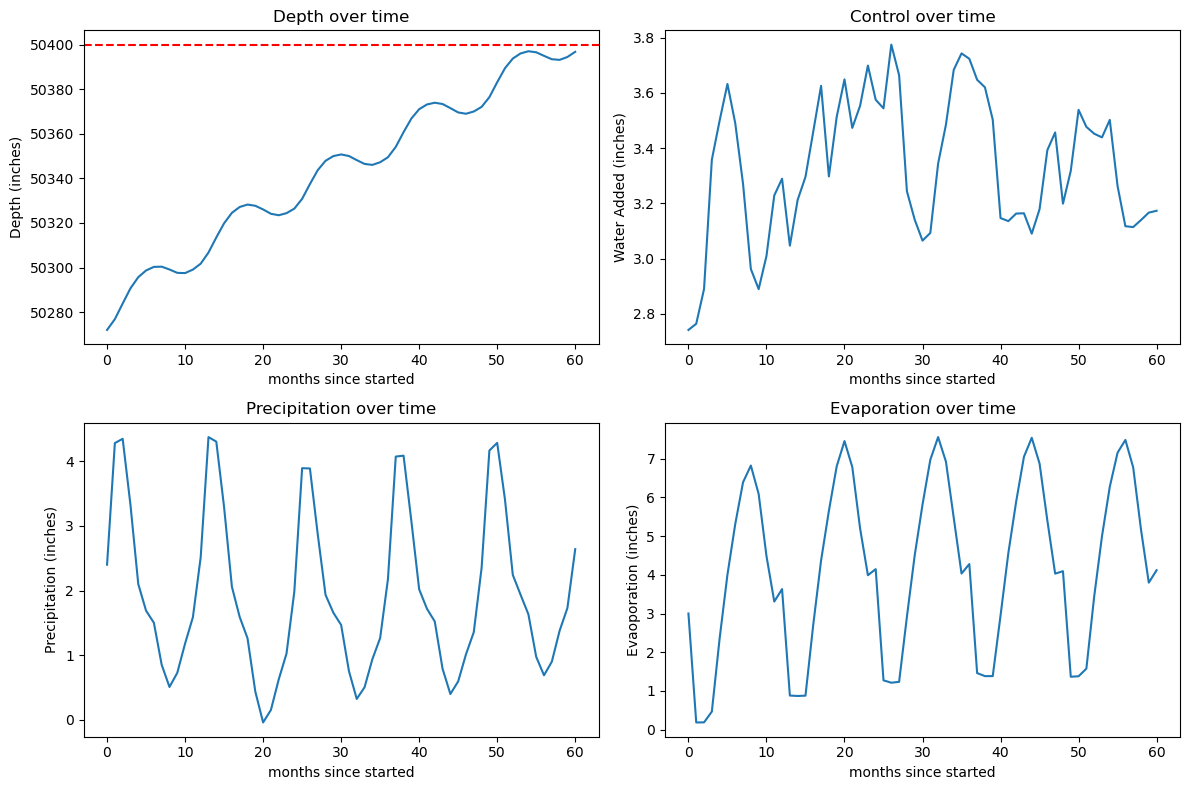

In [4]:
# Find state and control
sl = salt_lake(k1,k2,params,tf,x0)
x = sl.find_state()
t_vals = np.linspace(0, tf, tf+1)
x_vals = x(t_vals)
u = sl.find_control(t_vals)

# Plot depth
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.axhline(y = 50400, color = 'r', linestyle = '--')
# plt.plot(t_vals, x_vals[0])
plt.plot(t_vals, x_vals[0]+50400)
plt.xlabel('months since started')
# plt.ylabel('Difference in depth (inches)')
plt.ylabel('Depth (inches)')
# plt.title('Depth difference over time')
plt.title('Depth over time')

# Plot control
plt.subplot(2,2,2)
plt.plot(t_vals, u)
plt.xlabel('months since started')
plt.ylabel('Water Added (inches)')
plt.title('Control over time')

# Plot precipitation
plt.subplot(2,2,3)
plt.plot(t_vals, x_vals[1])
plt.xlabel('months since started')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation over time')

# Plot evaporation
plt.subplot(2,2,4)
plt.plot(t_vals, x_vals[2])
plt.xlabel('months since started')
plt.ylabel('Evaoporation (inches)')
plt.title('Evaporation over time')
plt.tight_layout()
plt.show()

# Try Many Parameters

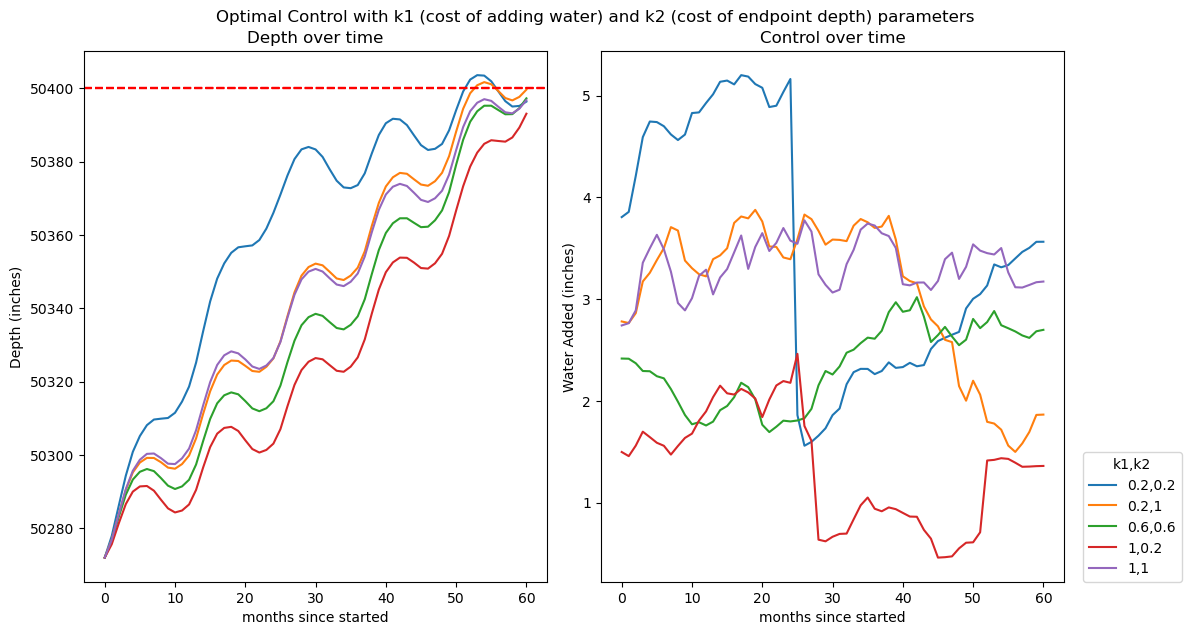

In [5]:
k_params = [[0.2,0.2],[0.2,1],[0.6,0.6],[1,0.2],[1,1]]
# plt.figure(figsize=(12,12))
# for alpha in [0.01,0.03,0.05,0.07,0.1,0.4,0.7,1]:
# for tf in [36,60,84,120]:
# for beta in [0.7,0.8,0.9,1]:
plt.figure(figsize=(12,12))
# for k1 in [0.2,0.6,1]:
#         for k2 in [0.2,0.6,1]:
for k in k_params:
        k1, k2 = k[0], k[1]
        # Set parameters
        alpha = 1
        beta = 0.75 #change in depth = alpha*rainfall + beta*evaporation
        epsilon = 0 #rainfall = epsilon*change in depth + lambda(t)
        delta = 0 #evaporation = delta*change in depth + gamma(t)
        row = .98
        tf = 60

        # Set x0
        # x0 = np.array([-128, 4.4, 0, 1])
        x0 = np.array([-128, 2.4, 3.0, 1])

        # Create parameter dict
        params = {'alpha': alpha, 'beta':beta, 'epsilon':epsilon,
                'delta': delta, 'row':row, 'gamma':gamma, 
                'lambda': lambda_}

        # Find state and control
        sl = salt_lake(k1,k2,params,tf,x0)
        x = sl.find_state()
        t_vals = np.linspace(0, tf, tf+1)
        x_vals = x(t_vals)
        u = sl.find_control(t_vals)

        # Plot depth
        plt.subplot(2,2,1)
        plt.axhline(y = 50400, color = 'r', linestyle = '--')
        # plt.plot(t_vals, x_vals[0], label=f'{k1},{k2}')
        plt.plot(t_vals, x_vals[0]+50400, label=f'{k1},{k2}')
        plt.xlabel('months since started')
        plt.ylabel('Depth (inches)')
        # plt.ylabel('Difference in depth (inches)')
        # plt.title('Depth difference over time')
        plt.title('Depth over time')

        # Plot control
        plt.subplot(2,2,2)
        plt.plot(t_vals, u, label=f'{k1},{k2}')
        plt.xlabel('months since started')
        plt.ylabel('Water Added (inches)')
        plt.title('Control over time')
plt.legend(loc=(1.04, 0), title='k1,k2')
plt.suptitle('Optimal Control with k1 (cost of adding water) and k2 (cost of endpoint depth) parameters')
plt.tight_layout()
plt.show()

            # # Plot precipitation
            # plt.subplot(2,2,3)
            # plt.plot(t_vals, x_vals[1])
            # plt.xlabel('months since started')
            # plt.ylabel('Precipitation')
            # plt.title('Precipitation over time')

            # # Plot evaporation
            # plt.subplot(2,2,4)
            # plt.plot(t_vals, x_vals[2])
            # plt.xlabel('months since started')
            # plt.ylabel('Evaoporation')
            # plt.title('Evaporation over time')
            # plt.tight_layout()
            # plt.show()

Setup and Choices:
-The gamma and lambda parameters will probably be discussed somewhere prior to this so I won't go into details about them here.
-Alpha was set to 1 (100%) because the data we used for this coefficient was based off of rainfall directly falling on the salt lake.
-Beta was set to 0.75 because evaporation is influenced by the salinity of the salt lake which is much higher than strawberry reservoir. 
-Epsilon and delta were set to zero because my state was the difference in depth (current - target) and so epsilon and delta didn't make sense for a difference state.
-I varied k1 and k2 (cost of adding water and cost of endpoint depth, respectively) to show their relative magnitudes impact on the optimal control. 
-I kept row above 0.9 (the one I used for the plot was 0.98) to reflect that most of our control's efforts were retained. For example 0.9 means 90% of our control's efforts were translated to water added into the lake. 
-tf=60 for a 5 year project (I have the plots varying this if we want to add these later).
-My final choice of initial condition was x0 = np.array([-128, 2.4, 3.0, 1]).

Observations and Conclusions:
Figure 1
-There is a periodic component of the great Salt Lake depth over time that matches the period of the precipitation over time.
Figure 2
-When we don't penalize the cost of adding water and the endpoint depth very much (0.2 for both, blue line) the optimal control adds 4-5 inches of water for about half the project length (~30 months) and then adds about half as much for the remaining 30 months. Notice that this hits the target lake depth first and even exceeds the target depth for some time. 
-When we do penalize the cost of adding water and the endpoint cost a lot (1 for both, purple line) then the optimal control consistently adds just over three inches for the entire duration of the project. 
-When we penalize the endpoint depth cost a lot more than the cost of adding water (orange line) then the final depth is exactly our target depth and the depth stays the closest to the target depth for the longest amount of time.
-When we penalize the cost of adding water a lot more than the endpoint depth cost (red line) then the final depth ends around 10 inches less than we hoped. Here the optimal control consistently adds the least number of inches on average. 